# 기술적 지표 (Technical Indicators) 조사

추가 설치 패키지
- [TA-Lib](http://ta-lib-org)
    - 고속 라이브러리
    - C/C++ 라이브러리의 래퍼 (Wrapper)
        - 원본 라이브러리가 설치되어 있어야 함
        - 설치가 복잡할 것임 
    - [WHL 설치](https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib) 

In [1]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [2]:
import numpy
import talib
from miscs.config_manager import ConfigManager
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *
import re

In [3]:
cm = ConfigManager('../config/.config.xml')

# 데이터 로딩

In [4]:
history_provider = MinuteChartDataProvider.Factory(cm, tag='history')

In [5]:
history_minute_dic = history_provider.get_history_from_ndays_ago(n_days=14)

특정 종목 (코스피 인버스)를 조사

In [6]:
df = history_minute_dic['114800']

<AxesSubplot:>

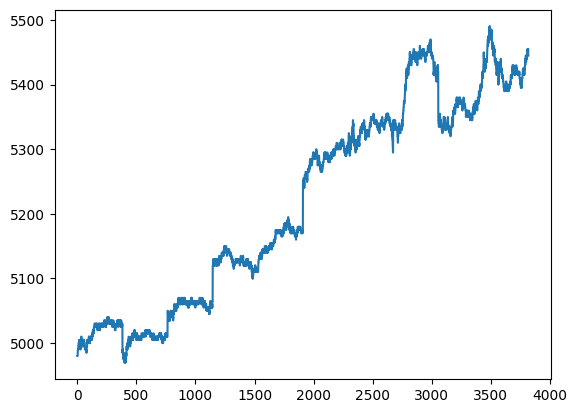

In [7]:
df['close'].plot(use_index=False)

# 기술적 지표

## 이동평균선

<AxesSubplot:>

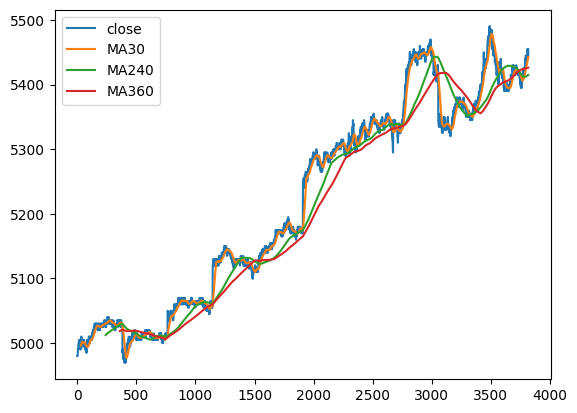

In [8]:
pd.concat((
  df.close,
  talib.MA(df['close'], timeperiod=30, matype=0).rename('MA30'),
  talib.MA(df['close'], timeperiod=4*60, matype=0).rename('MA240'),
  talib.MA(df['close'], timeperiod=6*60, matype=0).rename('MA360'),
), axis=1).plot(use_index=False)

<AxesSubplot:>

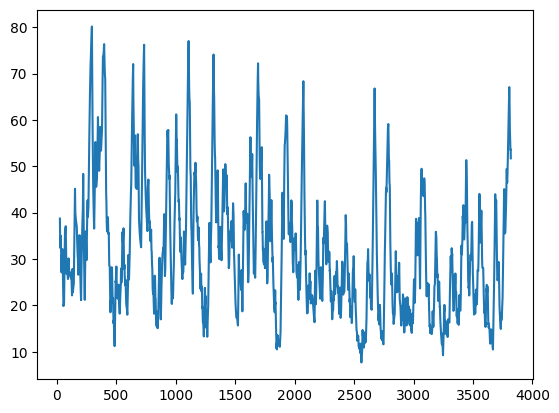

In [11]:
real.plot(use_index=False)

In [47]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

현재 문제점
- 분봉 데이터에 대해 rangebreaks가 제대로 동작하지 않음
- 길이가 400 보다 크면 (300~400 사이에서 문제가 시작됨) 중간이 끊겨버림

In [52]:
def make_pmas(df, x, include_candle=False):
  pmas = [ go.Scatter(
    x=x, 
    y=talib.MA(df['close'], timeperiod=window, matype=0).rename(f'MA{window}').values,
    name=f'MA{window}',
    # range_x=['2022-09-28', '2022-09-30']
    ) for window in [30, 120, 240, 360]
    ]
  if include_candle:
    pmas.append(go.Candlestick(x=x, open=df['open'], high=df['high'], low=df['low'], close=df['close'],
                        increasing_line_color='red', decreasing_line_color='blue', name='candle'))
  return pmas

In [35]:
def make_macd(df: pd.DataFrame, x):
  macd, macdsignal, macdhist = talib.MACD(df.close)
  return [
    go.Scatter(
      x=x, 
      y=macd,
      name='MACD',
      ),
    go.Scatter(
      x=x, 
      y=macdsignal,
      name='MACD Signal',
      ),
    go.Scatter(
      x=x, 
      y=macdhist,
      name='MACD Histogram',
      ),
  ]

In [56]:
def make_rsi(df: pd.DataFrame, x):
  rsi = talib.RSI(df.close)
  return [
    go.Scatter(
      x=x, 
      y=rsi,
      name='RSI',
      ),
  ]

In [58]:
def make_stochastic(df: pd.DataFrame, x):
  slowk, slowd = talib.STOCH(df.high, df.low, df.close)
  return [
    go.Scatter(
      x=x, 
      y=slowk,
      name='SlowK',
      ),
    go.Scatter(
      x=x, 
      y=slowd,
      name='SlowD',
      ),
  ]

In [60]:
def make_adx(df: pd.DataFrame, x):
  adx = talib.ADX(df.high, df.low, df.close)
  return [
    go.Scatter(
      x=x, 
      y=adx,
      name='ADX',
      ),
  ]

In [62]:
def make_ad(df: pd.DataFrame, x):
  ad = talib.AD(df.high, df.low, df.close, df.volume)
  return [
    go.Scatter(
      x=x, 
      y=ad,
      name='AD',
      ),
  ]

In [65]:
def make_obv(df: pd.DataFrame, x):
  obv = talib.OBV(df.close, df.volume)
  return [
    go.Scatter(
      x=x, 
      y=obv,
      name='OBV',
      ),
  ]

**rangebreaks** 문제

rangebreaks가 제대로 동작하지 않음
- 길이가 400 보다 크면 (300~400 사이에서 문제가 시작됨) 중간이 끊겨버림
- values가 제대로 워킹하지 않음

In [32]:
def print_data_chart(data:pd.DataFrame):
  """
  현재 문제점
  : 380개가 넘는 길이의 data를 그릴 때 망가진다. (plotly의 문제인가?)
  임사방편
  : bounds로 해결
  - 주말 제외
  TODO
  : 공휴일...
  """

  xindices = data.index.strftime(date_format='%Y-%m-%d %H:%M').values
  pdata = make_pmas(data, x=xindices)
  pdata += [go.Candlestick(x=xindices, open=data['open'], high=data['high'], low=data['low'], close=data['close'],
                        increasing_line_color='red', decreasing_line_color='blue', name='candle')]
  layout = {
    'xaxis': {'rangebreaks': [
                dict(bounds=["sat", "mon"]),
                dict(bounds=[15.51, 9], pattern='hour'), 
                dict(bounds=[15.33, 15.5], pattern='hour')
                ],
              'rangeslider': {'visible': False},
              'showgrid': True,
              'showticklabels': True,
              'nticks': 20
              },
  }

  fig = go.Figure(data=pdata, layout=layout)
  fig.show()
  return xindices
xindices = print_data_chart(df[-800:])

  **x축을 datetime을 사용하지 않는 방법**

  `tickvals` 와 `ticktext`로 해결
  
  단점
  - 그리드가 datetime의 경우와 달리 깔끔하게 나뉘지 않음
  - 확대시 틱 라벨이 사라짐
  - 호버 (hover) 시 툴팁의 x 좌표가 구분되지 않음

In [25]:
def show_chart_nodt(data:pd.DataFrame):
  data_naive = data.tz_localize(None)
  n= len(data_naive)
  dt_strs = data_naive.index.strftime(date_format='%m-%d %H:%M').values
  tickvals = pd.RangeIndex(0, n, n//10).values
  ticktext = list(map(lambda x: dt_strs[x], tickvals))

  xindices = pd.RangeIndex(0, n).values
  input = make_pmas(data_naive, x=xindices)
  input += [go.Candlestick(x=xindices, open=data['open'], high=data['high'], low=data['low'], close=data['close'],
                        increasing_line_color='red', decreasing_line_color='blue')]
  layout = {
    'xaxis': {'rangeslider': {'visible': False},
              'showgrid': True,
              'showticklabels': True,
              'tickvals': tickvals,
              'ticktext': ticktext,  
              },
  }
  fig = go.Figure(data=input, layout=layout)
  fig.show()
  return xindices, tickvals, ticktext

In [27]:
xindices, tickvals, ticktext = show_chart_nodt(df)

## Technical Indicators

In [38]:
data = df[-800:]
xindices = data.index.strftime(date_format='%Y-%m-%d %H:%M').values

In [49]:
def print_graphic_objects(pdata_primary, pdata_aux):
  """
  현재 문제점
  : 380개가 넘는 길이의 data를 그릴 때 망가진다. (plotly의 문제인가?)
  임사방편
  : bounds로 해결
  - 주말 제외
  TODO
  : 공휴일...
  """
  fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.5, 0.5], vertical_spacing=0.01)

  for p in pdata_primary: fig.append_trace(p, row=1, col=1)
  for p in pdata_aux: fig.append_trace(p, row=2, col=1)

  layout = {
    'height':800,
    'width':1024,
    'xaxis1': {'rangebreaks': [
                dict(bounds=["sat", "mon"]),
                dict(bounds=[15.51, 9], pattern='hour'), 
                dict(bounds=[15.33, 15.5], pattern='hour')
                ],
              'rangeslider': {'visible': False},
              'showgrid': True,
              'showticklabels': True,
              'nticks': 20
              },
     'xaxis2': {'rangebreaks': [
                dict(bounds=["sat", "mon"]),
                dict(bounds=[15.51, 9], pattern='hour'), 
                dict(bounds=[15.33, 15.5], pattern='hour')
                ],
              'rangeslider': {'visible': False},
              'showgrid': True,
              'showticklabels': True,
              'nticks': 20
              }, }

  fig.update_layout(**layout)
  fig.show()

MACD

In [53]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_macd(df=data, x=xindices))

RSI

In [57]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_rsi(df=data, x=xindices))

Stochastic Oscillator

In [59]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_stochastic(df=data, x=xindices))

ADX

In [61]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_adx(df=data, x=xindices))

AD

In [63]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_ad(df=data, x=xindices))

OBV

In [66]:
print_graphic_objects(make_pmas(df=data, x=xindices, include_candle=True), make_obv(df=data, x=xindices))